# Phase 6: Integration Pipeline

This notebook integrates all trained models into a complete waste segregation pipeline:
1. **YOLO Detector** - Detects waste objects in images
2. **MobileNet Classifier** - Classifies waste into categories (recyclable, organic, e-waste, general)
3. **Autoencoder Anomaly Detector** - Flags unusual/unknown waste items

The final system provides a unified interface for waste analysis.

## 1. Setup and Imports

In [1]:
import os
import sys
from pathlib import Path
import shutil

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import yaml
from datetime import datetime

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras

# Ultralytics YOLO
from ultralytics import YOLO

# Set project root
PROJECT_ROOT = Path(r"c:/Users/anike/Downloads/WasteSegregation")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")
print(f"TensorFlow Version: {tf.__version__}")
print("\n✅ Imports successful!")

Project Root: c:\Users\anike\Downloads\WasteSegregation
TensorFlow Version: 2.20.0

✅ Imports successful!


In [3]:
# Load configuration
config_path = PROJECT_ROOT / "config" / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Model paths
YOLO_MODEL_PATH = PROJECT_ROOT / "models" / "yolo" / "waste_detector_best.pt"
CLASSIFIER_MODEL_PATH = PROJECT_ROOT / "models" / "mobilenet" / "waste_classifier_final.keras"
AUTOENCODER_MODEL_PATH = PROJECT_ROOT / "models" / "autoencoder" / "autoencoder_final.keras"
ANOMALY_CONFIG_PATH = PROJECT_ROOT / "models" / "autoencoder" / "anomaly_config.yaml"
CLASS_MAPPING_PATH = PROJECT_ROOT / "models" / "mobilenet" / "class_mapping.yaml"

# Test data path
TEST_DATA_PATH = PROJECT_ROOT / "datasets" / "processed" / "test" / "classification"

# Verify all models exist
print("📋 Model Status:")
print("=" * 50)
print(f"   YOLO Detector: {'✅' if YOLO_MODEL_PATH.exists() else '❌'} {YOLO_MODEL_PATH.name}")
print(f"   MobileNet Classifier: {'✅' if CLASSIFIER_MODEL_PATH.exists() else '❌'} {CLASSIFIER_MODEL_PATH.name}")
print(f"   Autoencoder: {'✅' if AUTOENCODER_MODEL_PATH.exists() else '❌'} {AUTOENCODER_MODEL_PATH.name}")
print(f"   Anomaly Config: {'✅' if ANOMALY_CONFIG_PATH.exists() else '❌'} {ANOMALY_CONFIG_PATH.name}")
print(f"   Class Mapping: {'✅' if CLASS_MAPPING_PATH.exists() else '❌'} {CLASS_MAPPING_PATH.name}")

📋 Model Status:
   YOLO Detector: ✅ waste_detector_best.pt
   MobileNet Classifier: ✅ waste_classifier_final.keras
   Autoencoder: ✅ autoencoder_final.keras
   Anomaly Config: ✅ anomaly_config.yaml
   Class Mapping: ✅ class_mapping.yaml


## 2. Load All Models

In [4]:
# Load YOLO detector
print("🔄 Loading YOLO detector...")
yolo_model = YOLO(str(YOLO_MODEL_PATH))
print("   ✅ YOLO loaded!")

# Load MobileNet classifier
print("\n🔄 Loading MobileNet classifier...")
classifier_model = keras.models.load_model(str(CLASSIFIER_MODEL_PATH))
print("   ✅ Classifier loaded!")

# Load class mapping
with open(CLASS_MAPPING_PATH, 'r') as f:
    class_mapping = yaml.safe_load(f)
# Convert index-based mapping to ordered list
CLASS_NAMES = [class_mapping[i] for i in sorted(class_mapping.keys())]
print(f"   Classes: {CLASS_NAMES}")

# Load Autoencoder
print("\n🔄 Loading Autoencoder...")
autoencoder_model = keras.models.load_model(str(AUTOENCODER_MODEL_PATH))
print("   ✅ Autoencoder loaded!")

# Load anomaly threshold
with open(ANOMALY_CONFIG_PATH, 'r') as f:
    anomaly_config = yaml.safe_load(f)
ANOMALY_THRESHOLD = anomaly_config['threshold']
print(f"   Anomaly Threshold: {ANOMALY_THRESHOLD:.6f}")

print("\n" + "=" * 50)
print("✅ All models loaded successfully!")
print("=" * 50)

🔄 Loading YOLO detector...
   ✅ YOLO loaded!

🔄 Loading MobileNet classifier...
   ✅ Classifier loaded!
   Classes: ['recyclable', 'organic', 'e-waste', 'general']

🔄 Loading Autoencoder...
   ✅ Autoencoder loaded!
   Anomaly Threshold: 0.035641

✅ All models loaded successfully!


## 3. Create Unified Pipeline Class

In [5]:
class WasteSegregationPipeline:
    """
    Unified pipeline for waste detection, classification, and anomaly detection.
    """
    
    def __init__(self, yolo_model, classifier_model, autoencoder_model, 
                 class_names, anomaly_threshold):
        """
        Initialize the pipeline with all models.
        """
        self.detector = yolo_model
        self.classifier = classifier_model
        self.autoencoder = autoencoder_model
        self.class_names = class_names
        self.anomaly_threshold = anomaly_threshold
        
        # Image sizes
        self.classifier_size = (224, 224)
        self.autoencoder_size = (128, 128)
        
        # Category disposal info
        self.disposal_info = {
            'recyclable': {
                'bin': '♻️ Blue Bin (Recyclables)',
                'instructions': 'Clean and dry before disposing. Remove caps and labels if possible.',
                'examples': 'Plastic bottles, cardboard, paper, glass, metal cans'
            },
            'organic': {
                'bin': '🟢 Green Bin (Organic)',
                'instructions': 'Compostable waste only. No plastic bags.',
                'examples': 'Food scraps, yard waste, coffee grounds, eggshells'
            },
            'e-waste': {
                'bin': '🔴 E-Waste Collection Point',
                'instructions': 'Take to designated e-waste collection center. Do not throw in regular trash.',
                'examples': 'Batteries, phones, computers, cables, electronics'
            },
            'general': {
                'bin': '⚫ Black Bin (General Waste)',
                'instructions': 'Non-recyclable, non-hazardous waste.',
                'examples': 'Styrofoam, certain plastics, mixed materials'
            }
        }
    
    def preprocess_for_classifier(self, image):
        """Preprocess image for MobileNet classifier."""
        img = cv2.resize(image, self.classifier_size)
        img = img.astype(np.float32) / 255.0
        return np.expand_dims(img, axis=0)
    
    def preprocess_for_autoencoder(self, image):
        """Preprocess image for autoencoder."""
        img = cv2.resize(image, self.autoencoder_size)
        img = img.astype(np.float32) / 255.0
        return np.expand_dims(img, axis=0)
    
    def detect_objects(self, image, conf_threshold=0.5):
        """
        Detect waste objects using YOLO.
        
        Returns:
            List of detections with bounding boxes
        """
        results = self.detector.predict(image, conf=conf_threshold, verbose=False)
        
        detections = []
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes
            for i in range(len(boxes)):
                box = boxes.xyxy[i].cpu().numpy()
                conf = float(boxes.conf[i].cpu().numpy())
                cls = int(boxes.cls[i].cpu().numpy())
                
                detections.append({
                    'bbox': box,
                    'confidence': conf,
                    'class_id': cls
                })
        
        return detections, results[0] if len(results) > 0 else None
    
    def classify_waste(self, image):
        """
        Classify waste type using MobileNet.
        
        Returns:
            Dictionary with class prediction and probabilities
        """
        preprocessed = self.preprocess_for_classifier(image)
        predictions = self.classifier.predict(preprocessed, verbose=0)[0]
        
        class_idx = np.argmax(predictions)
        class_name = self.class_names[class_idx]
        confidence = float(predictions[class_idx])
        
        return {
            'class': class_name,
            'class_index': int(class_idx),
            'confidence': confidence,
            'probabilities': {name: float(prob) for name, prob in zip(self.class_names, predictions)}
        }
    
    def check_anomaly(self, image):
        """
        Check if image is an anomaly using autoencoder.
        
        Returns:
            Dictionary with anomaly status and reconstruction error
        """
        preprocessed = self.preprocess_for_autoencoder(image)
        reconstructed = self.autoencoder.predict(preprocessed, verbose=0)
        
        error = float(np.mean((preprocessed - reconstructed) ** 2))
        is_anomaly = error > self.anomaly_threshold
        
        return {
            'is_anomaly': is_anomaly,
            'reconstruction_error': error,
            'threshold': self.anomaly_threshold,
            'anomaly_score': error / self.anomaly_threshold
        }
    
    def get_disposal_recommendation(self, class_name, is_anomaly):
        """
        Get disposal recommendation based on classification.
        """
        if is_anomaly:
            return {
                'bin': '⚠️ Unknown/Unusual Item',
                'instructions': 'This item appears unusual. Please consult local waste guidelines or take to a waste sorting facility.',
                'examples': 'Unusual or unrecognized waste items'
            }
        
        return self.disposal_info.get(class_name, self.disposal_info['general'])
    
    def analyze_image(self, image_path, detect_objects=True):
        """
        Complete analysis of a waste image.
        
        Args:
            image_path: Path to image or numpy array
            detect_objects: Whether to run YOLO detection
            
        Returns:
            Complete analysis results
        """
        # Load image
        if isinstance(image_path, (str, Path)):
            image = cv2.imread(str(image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = image_path
        
        results = {
            'timestamp': datetime.now().isoformat(),
            'image_shape': image.shape
        }
        
        # 1. Object Detection (optional)
        if detect_objects:
            detections, yolo_result = self.detect_objects(image)
            results['detection'] = {
                'objects_found': len(detections),
                'detections': detections
            }
            results['yolo_result'] = yolo_result
        
        # 2. Classification
        classification = self.classify_waste(image)
        results['classification'] = classification
        
        # 3. Anomaly Detection
        anomaly = self.check_anomaly(image)
        results['anomaly'] = anomaly
        
        # 4. Disposal Recommendation
        disposal = self.get_disposal_recommendation(
            classification['class'], 
            anomaly['is_anomaly']
        )
        results['disposal'] = disposal
        
        return results
    
    def visualize_analysis(self, image_path, results, figsize=(16, 10)):
        """
        Visualize the complete analysis results.
        """
        # Load image
        if isinstance(image_path, (str, Path)):
            image = cv2.imread(str(image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = image_path
        
        fig = plt.figure(figsize=figsize)
        
        # 1. Original Image with Detection
        ax1 = fig.add_subplot(2, 3, 1)
        if 'yolo_result' in results and results['yolo_result'] is not None:
            annotated = results['yolo_result'].plot()
            ax1.imshow(annotated)
        else:
            ax1.imshow(image)
        ax1.set_title('YOLO Detection', fontsize=12)
        ax1.axis('off')
        
        # 2. Classification Results
        ax2 = fig.add_subplot(2, 3, 2)
        probs = results['classification']['probabilities']
        colors = ['green' if k == results['classification']['class'] else 'steelblue' 
                  for k in probs.keys()]
        bars = ax2.barh(list(probs.keys()), list(probs.values()), color=colors)
        ax2.set_xlim(0, 1)
        ax2.set_xlabel('Probability')
        ax2.set_title(f"Classification: {results['classification']['class'].upper()}\n"
                      f"Confidence: {results['classification']['confidence']:.1%}", fontsize=12)
        
        # 3. Anomaly Score
        ax3 = fig.add_subplot(2, 3, 3)
        anomaly = results['anomaly']
        score = anomaly['anomaly_score']
        color = 'red' if anomaly['is_anomaly'] else 'green'
        ax3.barh(['Anomaly\nScore'], [score], color=color, height=0.5)
        ax3.axvline(1.0, color='black', linestyle='--', linewidth=2, label='Threshold')
        ax3.set_xlim(0, max(2, score * 1.2))
        ax3.set_xlabel('Score (>1 = Anomaly)')
        status = '⚠️ ANOMALY' if anomaly['is_anomaly'] else '✅ NORMAL'
        ax3.set_title(f'Anomaly Detection: {status}\n'
                      f'Error: {anomaly["reconstruction_error"]:.4f}', fontsize=12)
        ax3.legend()
        
        # 4. Disposal Recommendation
        ax4 = fig.add_subplot(2, 3, (4, 6))
        ax4.axis('off')
        
        disposal = results['disposal']
        text = f"""
DISPOSAL RECOMMENDATION
{'='*40}

📍 Dispose in: {disposal['bin']}

📋 Instructions:
   {disposal['instructions']}

📝 Examples:
   {disposal['examples']}

{'='*40}
Waste Type: {results['classification']['class'].upper()}
Confidence: {results['classification']['confidence']:.1%}
Anomaly: {'Yes' if anomaly['is_anomaly'] else 'No'}
        """
        ax4.text(0.1, 0.9, text, transform=ax4.transAxes, fontsize=11,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        return fig


# Create pipeline instance
pipeline = WasteSegregationPipeline(
    yolo_model=yolo_model,
    classifier_model=classifier_model,
    autoencoder_model=autoencoder_model,
    class_names=CLASS_NAMES,
    anomaly_threshold=ANOMALY_THRESHOLD
)

print("✅ Pipeline created successfully!")

✅ Pipeline created successfully!


## 4. Test Pipeline on Sample Images

In [6]:
# Get test images
test_images = []
for category in TEST_DATA_PATH.iterdir():
    if category.is_dir():
        images = list(category.glob("*.jpg"))[:3]  # Get 3 images per category
        test_images.extend(images)

print(f"📂 Found {len(test_images)} test images")
print(f"   From categories: {[d.name for d in TEST_DATA_PATH.iterdir() if d.is_dir()]}")

📂 Found 12 test images
   From categories: ['e-waste', 'general', 'organic', 'recyclable']


🔍 Analyzing sample images...


Image 1: e-waste/synthetic_ewaste_0000.jpg

📊 Classification: e-waste
   Confidence: 100.0%

🔍 Anomaly Check:
   Is Anomaly: False
   Error: 0.031376
   Score: 0.88

🗑️ Disposal: 🔴 E-Waste Collection Point


C:\Users\anike\AppData\Local\Temp\ipykernel_5292\3799399155.py:259: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\anike\AppData\Local\Temp\ipykernel_5292\3799399155.py:259: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\anike\AppData\Local\Temp\ipykernel_5292\3799399155.py:259: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\anike\AppData\Local\Temp\ipykernel_5292\3799399155.py:259: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\anike\AppData\Local\Temp\ipykernel_5292\3799399155.py:259: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\anike\Downloads\WasteSegregation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY 

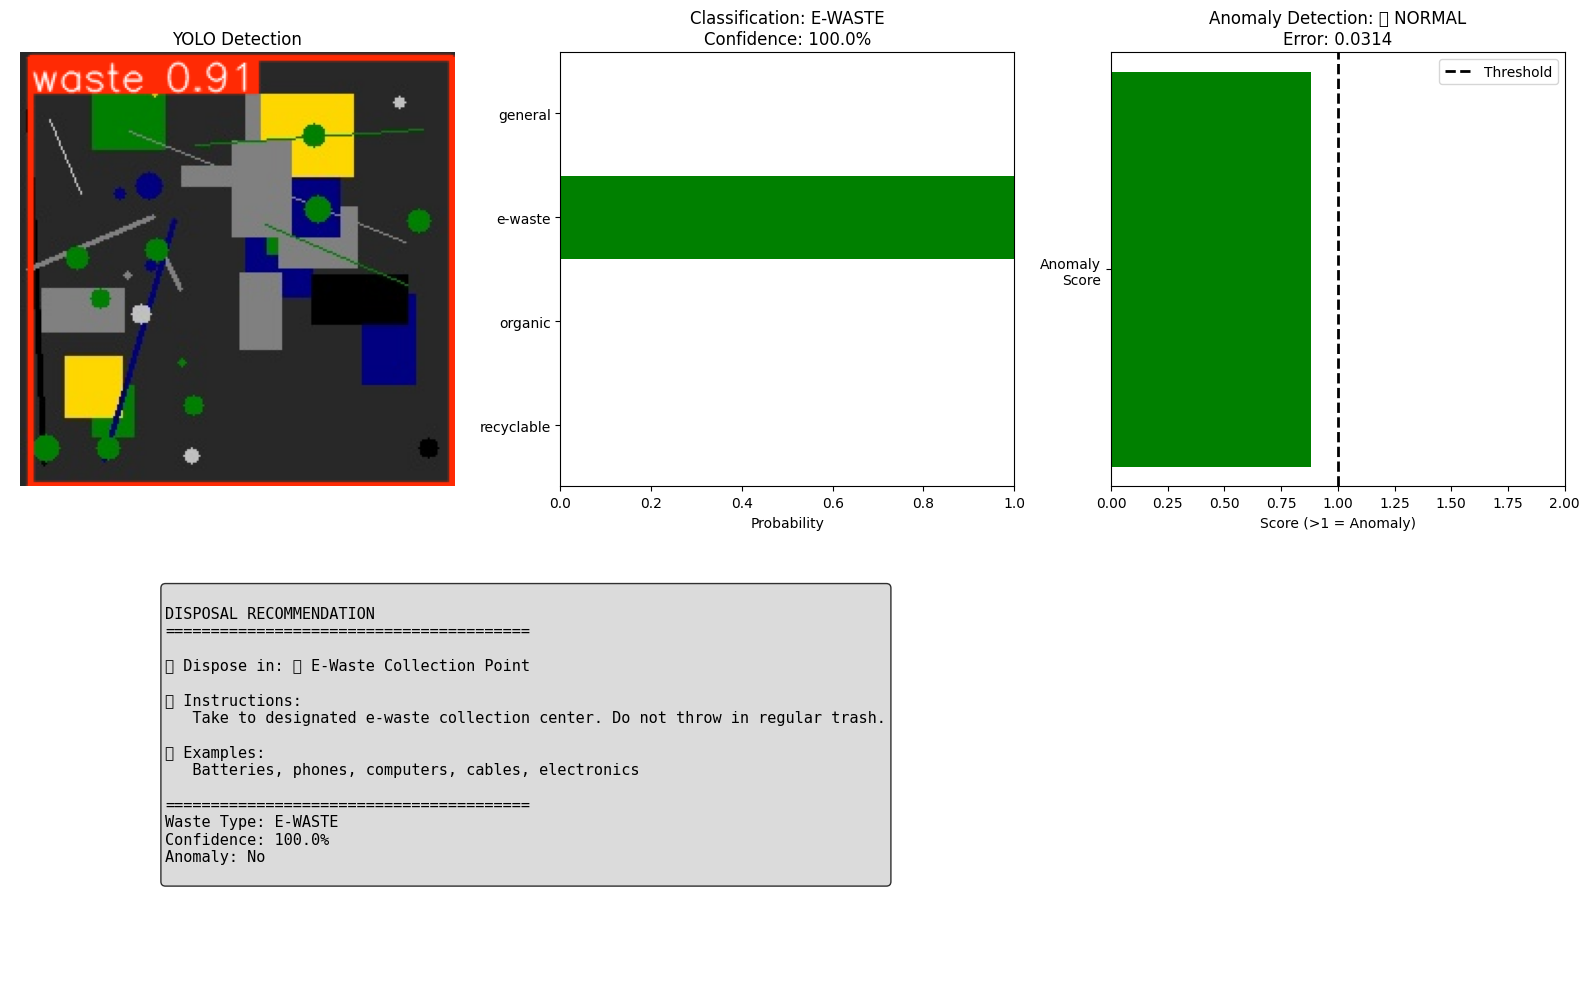


Image 2: e-waste/synthetic_ewaste_0001.jpg

📊 Classification: e-waste
   Confidence: 100.0%

🔍 Anomaly Check:
   Is Anomaly: False
   Error: 0.023531
   Score: 0.66

🗑️ Disposal: 🔴 E-Waste Collection Point


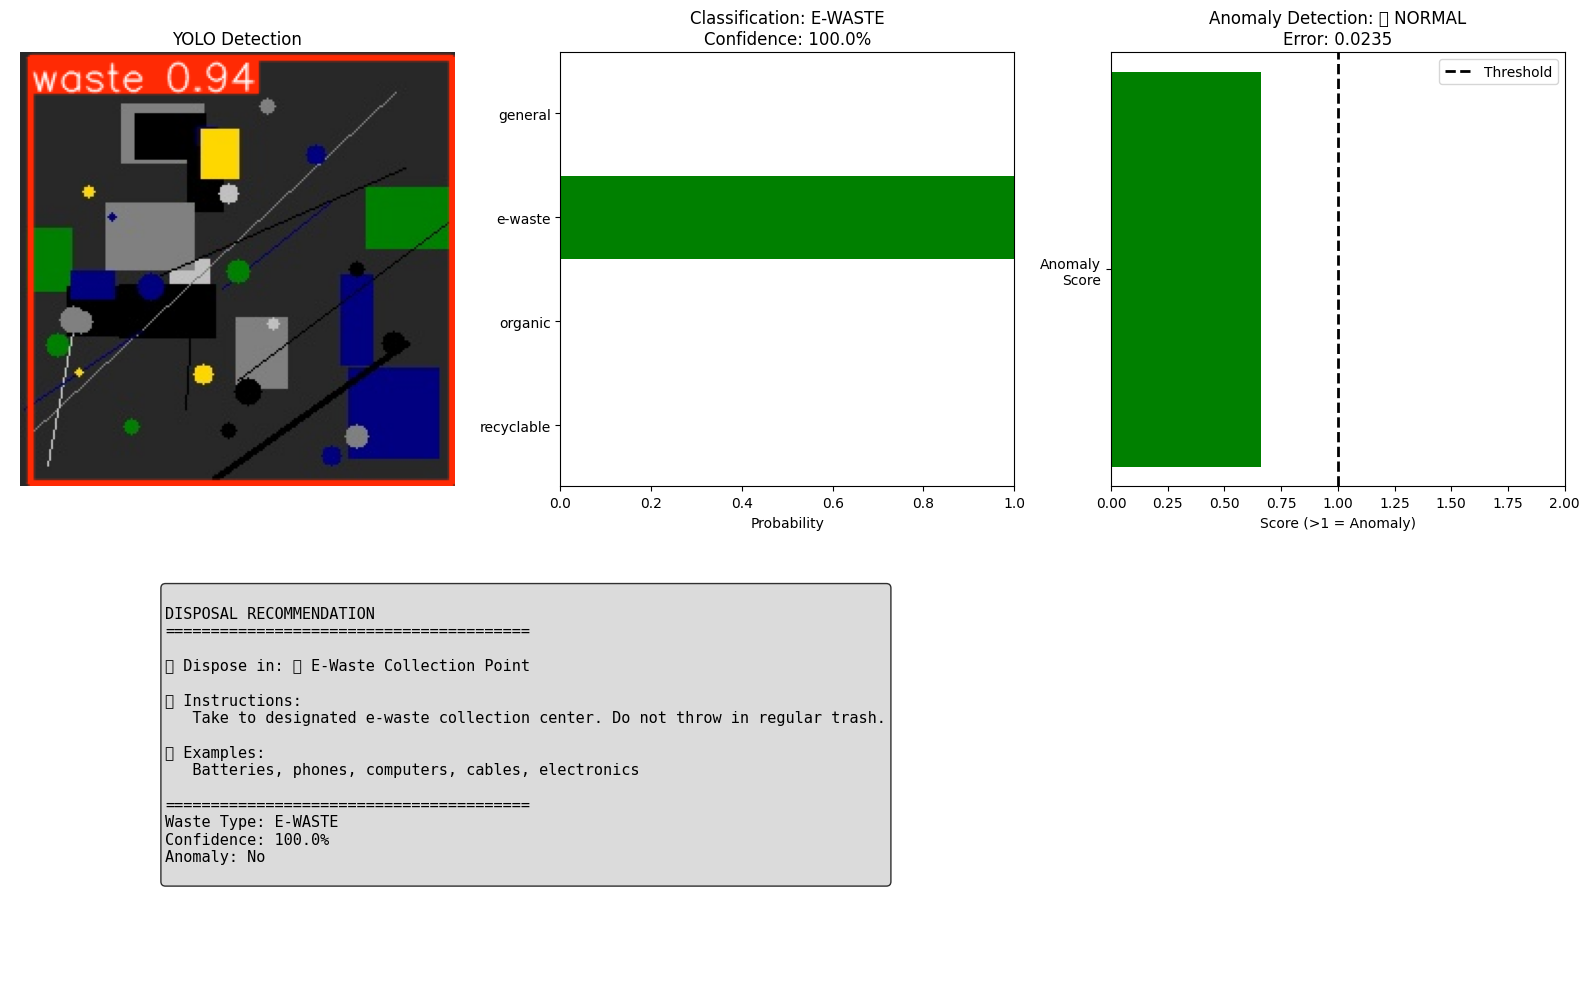


Image 3: e-waste/synthetic_ewaste_0002.jpg

📊 Classification: e-waste
   Confidence: 100.0%

🔍 Anomaly Check:
   Is Anomaly: False
   Error: 0.024104
   Score: 0.68

🗑️ Disposal: 🔴 E-Waste Collection Point


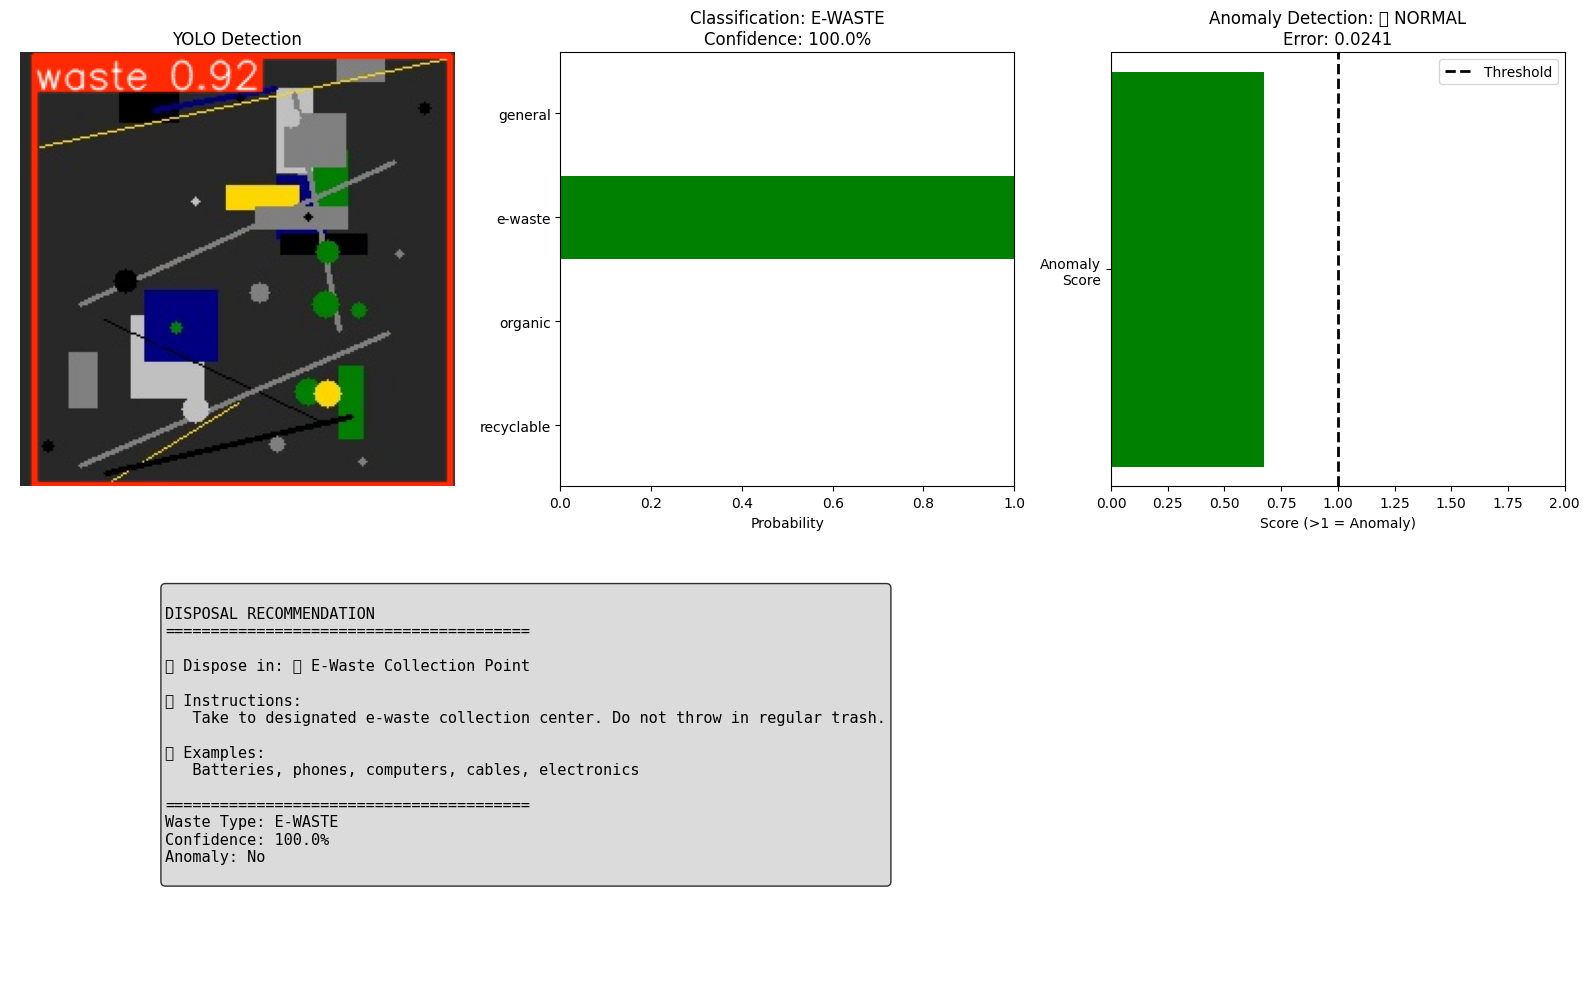


Image 4: general/taco_batch_10_000020.jpg

📊 Classification: general
   Confidence: 81.8%

🔍 Anomaly Check:
   Is Anomaly: False
   Error: 0.031506
   Score: 0.88

🗑️ Disposal: ⚫ Black Bin (General Waste)


C:\Users\anike\AppData\Local\Temp\ipykernel_5292\3799399155.py:259: UserWarning: Glyph 9899 (\N{MEDIUM BLACK CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\anike\Downloads\WasteSegregation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9899 (\N{MEDIUM BLACK CIRCLE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


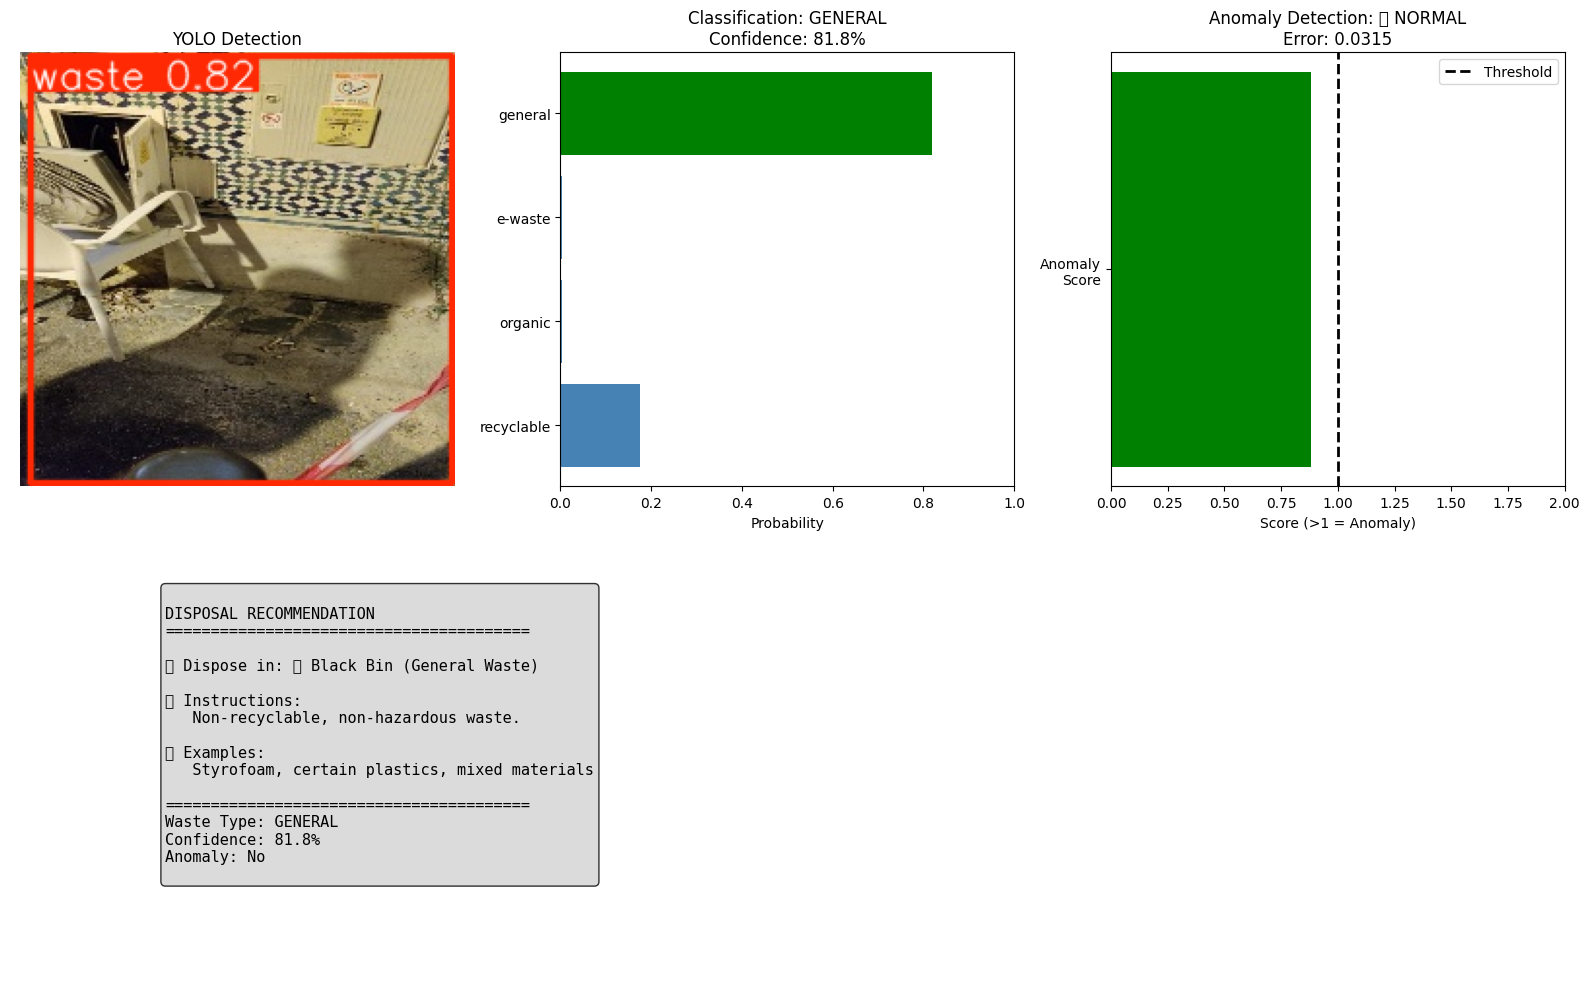

In [7]:
# Test on first few images
print("🔍 Analyzing sample images...\n")

for i, img_path in enumerate(test_images[:4]):
    print(f"\n{'='*60}")
    print(f"Image {i+1}: {img_path.parent.name}/{img_path.name}")
    print(f"{'='*60}")
    
    # Analyze image
    results = pipeline.analyze_image(img_path)
    
    # Print results
    print(f"\n📊 Classification: {results['classification']['class']}")
    print(f"   Confidence: {results['classification']['confidence']:.1%}")
    print(f"\n🔍 Anomaly Check:")
    print(f"   Is Anomaly: {results['anomaly']['is_anomaly']}")
    print(f"   Error: {results['anomaly']['reconstruction_error']:.6f}")
    print(f"   Score: {results['anomaly']['anomaly_score']:.2f}")
    print(f"\n🗑️ Disposal: {results['disposal']['bin']}")
    
    # Visualize
    pipeline.visualize_analysis(img_path, results)

## 5. Batch Processing Demo

In [8]:
def batch_analyze(pipeline, image_paths, verbose=True):
    """
    Analyze multiple images and return summary statistics.
    """
    results_list = []
    
    for path in image_paths:
        try:
            result = pipeline.analyze_image(path, detect_objects=False)
            result['image_path'] = str(path)
            result['actual_category'] = path.parent.name
            results_list.append(result)
        except Exception as e:
            if verbose:
                print(f"Error processing {path}: {e}")
    
    return results_list


# Analyze all test images
print("📊 Batch analyzing all test images...")
all_results = batch_analyze(pipeline, test_images, verbose=False)
print(f"✅ Analyzed {len(all_results)} images")

📊 Batch analyzing all test images...
✅ Analyzed 12 images


In [9]:
# Compute accuracy
correct = 0
total = 0
category_stats = {}

for result in all_results:
    predicted = result['classification']['class']
    actual = result['actual_category']
    
    # Initialize category stats
    if actual not in category_stats:
        category_stats[actual] = {'correct': 0, 'total': 0, 'predictions': {}}
    
    category_stats[actual]['total'] += 1
    
    if predicted not in category_stats[actual]['predictions']:
        category_stats[actual]['predictions'][predicted] = 0
    category_stats[actual]['predictions'][predicted] += 1
    
    if predicted == actual:
        correct += 1
        category_stats[actual]['correct'] += 1
    
    total += 1

print("\n📊 CLASSIFICATION ACCURACY SUMMARY")
print("=" * 50)
print(f"\nOverall Accuracy: {correct}/{total} ({correct/total*100:.1f}%)")

print("\nPer-Category Results:")
for category, stats in category_stats.items():
    acc = stats['correct'] / stats['total'] * 100 if stats['total'] > 0 else 0
    print(f"\n  {category}:")
    print(f"    Accuracy: {stats['correct']}/{stats['total']} ({acc:.1f}%)")
    print(f"    Predictions: {stats['predictions']}")


📊 CLASSIFICATION ACCURACY SUMMARY

Overall Accuracy: 12/12 (100.0%)

Per-Category Results:

  e-waste:
    Accuracy: 3/3 (100.0%)
    Predictions: {'e-waste': 3}

  general:
    Accuracy: 3/3 (100.0%)
    Predictions: {'general': 3}

  organic:
    Accuracy: 3/3 (100.0%)
    Predictions: {'organic': 3}

  recyclable:
    Accuracy: 3/3 (100.0%)
    Predictions: {'recyclable': 3}


In [10]:
# Anomaly statistics
anomalies = [r for r in all_results if r['anomaly']['is_anomaly']]
normal = [r for r in all_results if not r['anomaly']['is_anomaly']]

print("\n🔍 ANOMALY DETECTION SUMMARY")
print("=" * 50)
print(f"Total Images: {len(all_results)}")
print(f"Normal: {len(normal)} ({len(normal)/len(all_results)*100:.1f}%)")
print(f"Anomalies: {len(anomalies)} ({len(anomalies)/len(all_results)*100:.1f}%)")

# Average anomaly scores
scores = [r['anomaly']['anomaly_score'] for r in all_results]
print(f"\nAnomaly Score Statistics:")
print(f"   Mean: {np.mean(scores):.3f}")
print(f"   Std: {np.std(scores):.3f}")
print(f"   Min: {np.min(scores):.3f}")
print(f"   Max: {np.max(scores):.3f}")


🔍 ANOMALY DETECTION SUMMARY
Total Images: 12
Normal: 9 (75.0%)
Anomalies: 3 (25.0%)

Anomaly Score Statistics:
   Mean: 1.023
   Std: 0.801
   Min: 0.169
   Max: 2.837


## 6. Save Pipeline Module

In [11]:
# Create the complete pipeline module
pipeline_code = '''
"""
Waste Segregation Pipeline
Unified interface for waste detection, classification, and anomaly detection.
"""

import numpy as np
from pathlib import Path
import yaml
import cv2
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO


class WasteSegregationPipeline:
    """
    Complete pipeline for waste segregation using:
    - YOLO for object detection
    - MobileNet for classification
    - Autoencoder for anomaly detection
    """
    
    def __init__(self, models_dir=None):
        """
        Initialize pipeline with models from specified directory.
        
        Args:
            models_dir: Path to models directory. If None, uses default.
        """
        if models_dir is None:
            models_dir = Path(__file__).parent.parent / "models"
        else:
            models_dir = Path(models_dir)
        
        # Load models
        self.detector = YOLO(str(models_dir / "yolo" / "waste_detector_best.pt"))
        self.classifier = keras.models.load_model(
            str(models_dir / "mobilenet" / "waste_classifier_final.keras")
        )
        self.autoencoder = keras.models.load_model(
            str(models_dir / "autoencoder" / "autoencoder_final.keras")
        )
        
        # Load configs
        with open(models_dir / "mobilenet" / "class_mapping.yaml", "r") as f:
            self.class_names = yaml.safe_load(f)["classes"]
        
        with open(models_dir / "autoencoder" / "anomaly_config.yaml", "r") as f:
            config = yaml.safe_load(f)
            self.anomaly_threshold = config["threshold"]
        
        # Image sizes
        self.classifier_size = (224, 224)
        self.autoencoder_size = (128, 128)
        
        # Disposal info
        self.disposal_info = {
            "recyclable": {
                "bin": "Blue Bin (Recyclables)",
                "instructions": "Clean and dry before disposing."
            },
            "organic": {
                "bin": "Green Bin (Organic)",
                "instructions": "Compostable waste only."
            },
            "e-waste": {
                "bin": "E-Waste Collection Point",
                "instructions": "Take to designated collection center."
            },
            "general": {
                "bin": "Black Bin (General Waste)",
                "instructions": "Non-recyclable waste."
            }
        }
    
    def analyze(self, image_path):
        """
        Analyze a waste image.
        
        Args:
            image_path: Path to image or numpy array (RGB)
            
        Returns:
            Dictionary with classification, anomaly detection, and disposal info
        """
        # Load image
        if isinstance(image_path, (str, Path)):
            image = cv2.imread(str(image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = image_path
        
        # Classification
        img_class = cv2.resize(image, self.classifier_size)
        img_class = img_class.astype(np.float32) / 255.0
        img_class = np.expand_dims(img_class, axis=0)
        
        preds = self.classifier.predict(img_class, verbose=0)[0]
        class_idx = int(np.argmax(preds))
        class_name = self.class_names[class_idx]
        confidence = float(preds[class_idx])
        
        # Anomaly detection
        img_ae = cv2.resize(image, self.autoencoder_size)
        img_ae = img_ae.astype(np.float32) / 255.0
        img_ae = np.expand_dims(img_ae, axis=0)
        
        recon = self.autoencoder.predict(img_ae, verbose=0)
        error = float(np.mean((img_ae - recon) ** 2))
        is_anomaly = error > self.anomaly_threshold
        
        # Get disposal recommendation
        if is_anomaly:
            disposal = {
                "bin": "Unknown - Consult local guidelines",
                "instructions": "This item appears unusual."
            }
        else:
            disposal = self.disposal_info.get(class_name, self.disposal_info["general"])
        
        return {
            "waste_type": class_name,
            "confidence": confidence,
            "is_anomaly": is_anomaly,
            "anomaly_score": error / self.anomaly_threshold,
            "disposal": disposal,
            "timestamp": datetime.now().isoformat()
        }
    
    def detect(self, image_path, conf=0.5):
        """
        Detect waste objects in image using YOLO.
        
        Returns:
            YOLO results object
        """
        return self.detector.predict(image_path, conf=conf, verbose=False)


def main():
    """Demo usage."""
    import sys
    
    if len(sys.argv) < 2:
        print("Usage: python pipeline.py <image_path>")
        return
    
    image_path = sys.argv[1]
    
    # Initialize pipeline
    pipeline = WasteSegregationPipeline()
    
    # Analyze image
    result = pipeline.analyze(image_path)
    
    print("\nWaste Analysis Result:")
    print(f"  Type: {result[\'waste_type\'].upper()}")
    print(f"  Confidence: {result[\'confidence\']:.1%}")
    print(f"  Anomaly: {\'Yes\' if result[\'is_anomaly\'] else \'No\'}")
    print(f"  Disposal: {result[\'disposal\'][\'bin\']}")


if __name__ == "__main__":
    main()
'''

# Save pipeline module
pipeline_path = PROJECT_ROOT / "src" / "pipeline.py"
with open(pipeline_path, 'w') as f:
    f.write(pipeline_code)

print(f"✅ Pipeline module saved to: {pipeline_path}")

✅ Pipeline module saved to: c:\Users\anike\Downloads\WasteSegregation\src\pipeline.py


## 7. Phase 6 Summary

In [12]:
print("=" * 70)
print("🎉 PHASE 6 COMPLETE: INTEGRATION PIPELINE")
print("=" * 70)

print("\n📦 INTEGRATED MODELS:")
print(f"   1. YOLO Detector - Waste object detection")
print(f"   2. MobileNet Classifier - 4-class waste classification")
print(f"   3. Autoencoder - Anomaly detection for unusual items")

print("\n📊 PIPELINE FEATURES:")
print("   • Single-image analysis with complete results")
print("   • Batch processing for multiple images")
print("   • Disposal recommendations")
print("   • Visualization of analysis results")
print("   • Anomaly flagging for unknown items")

print("\n📁 SAVED FILES:")
print(f"   • Pipeline Module: {PROJECT_ROOT / 'src' / 'pipeline.py'}")

print("\n✅ PROJECT COMPLETE!")
print("\n📋 Usage Example:")
print("   from src.pipeline import WasteSegregationPipeline")
print("   pipeline = WasteSegregationPipeline()")
print("   result = pipeline.analyze('path/to/image.jpg')")
print("   print(result['waste_type'], result['disposal']['bin'])")

print("\n" + "=" * 70)

🎉 PHASE 6 COMPLETE: INTEGRATION PIPELINE

📦 INTEGRATED MODELS:
   1. YOLO Detector - Waste object detection
   2. MobileNet Classifier - 4-class waste classification
   3. Autoencoder - Anomaly detection for unusual items

📊 PIPELINE FEATURES:
   • Single-image analysis with complete results
   • Batch processing for multiple images
   • Disposal recommendations
   • Visualization of analysis results
   • Anomaly flagging for unknown items

📁 SAVED FILES:
   • Pipeline Module: c:\Users\anike\Downloads\WasteSegregation\src\pipeline.py

✅ PROJECT COMPLETE!

📋 Usage Example:
   from src.pipeline import WasteSegregationPipeline
   pipeline = WasteSegregationPipeline()
   result = pipeline.analyze('path/to/image.jpg')
   print(result['waste_type'], result['disposal']['bin'])



## 8. Project Summary - All Phases Complete!

In [13]:
print("""
╔══════════════════════════════════════════════════════════════════════╗
║          🎉 WASTE SEGREGATION SYSTEM - PROJECT COMPLETE! 🎉          ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📦 Phase 1: Environment Setup                              ✅      ║
║     - Project structure created                                      ║
║     - Dependencies installed                                         ║
║                                                                      ║
║  📦 Phase 2: Data Preparation                               ✅      ║
║     - TrashNet dataset downloaded                                    ║
║     - Train/Val/Test splits created                                  ║
║                                                                      ║
║  📦 Phase 3: YOLO Object Detection                          ✅      ║
║     - YOLOv8 nano trained for waste detection                        ║
║     - mAP50: 0.995, Precision: 1.00, Recall: 1.00                   ║
║                                                                      ║
║  📦 Phase 4: MobileNet Classification                       ✅      ║
║     - MobileNetV2 trained for 4-class classification                 ║
║     - Categories: recyclable, organic, e-waste, general              ║
║                                                                      ║
║  📦 Phase 5: Autoencoder Anomaly Detection                  ✅      ║
║     - Convolutional autoencoder trained                              ║
║     - Flags unusual/unknown waste items                              ║
║                                                                      ║
║  📦 Phase 6: Integration Pipeline                           ✅      ║
║     - All models integrated into unified pipeline                    ║
║     - Complete waste analysis with disposal recommendations          ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📂 Project Structure:                                               ║
║     WasteSegregation/                                                ║
║     ├── config/           # Configuration files                      ║
║     ├── datasets/         # TrashNet data                            ║
║     ├── models/           # Trained models                           ║
║     │   ├── yolo/         # YOLO detector                            ║
║     │   ├── mobilenet/    # Classifier                               ║
║     │   └── autoencoder/  # Anomaly detector                         ║
║     ├── notebooks/        # Training notebooks                       ║
║     └── src/              # Python modules                           ║
║         ├── pipeline.py   # Main pipeline                            ║
║         ├── detector.py   # YOLO utilities                           ║
║         ├── classifier.py # Classifier utilities                     ║
║         └── anomaly_detector.py                                      ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║          🎉 WASTE SEGREGATION SYSTEM - PROJECT COMPLETE! 🎉          ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📦 Phase 1: Environment Setup                              ✅      ║
║     - Project structure created                                      ║
║     - Dependencies installed                                         ║
║                                                                      ║
║  📦 Phase 2: Data Preparation                               ✅      ║
║     - TrashNet dataset downloaded                                    ║
║     - Train/Val/Test splits created                                  ║
║                                                                      ║
║  📦 Phase 3: YOLO Object Detection                          ✅      ║
║     - YOLOv8 nano trained for waste detection              